# This code is a permutation test

In [18]:
# Initialize environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import List, Union
import ta as ta

In [ ]:
# Load data
df = pd.read_feather('data/ETH_USD-1h.feather')
df.set_index('date', inplace=True)

# Define permutation code

In [ ]:
def get_permutation(
    ohlc: Union[pd.DataFrame, List[pd.DataFrame]], start_index: int = 0, seed=None
):
    assert start_index >= 0

    np.random.seed(seed)

    if isinstance(ohlc, list):
        time_index = ohlc[0].index
        for mkt in ohlc:
            assert np.all(time_index == mkt.index), "Indexes do not match"
        n_markets = len(ohlc)
    else:
        n_markets = 1
        time_index = ohlc.index
        ohlc = [ohlc]

    n_bars = len(ohlc[0])

    perm_index = start_index + 1
    perm_n = n_bars - perm_index

    start_bar = np.empty((n_markets, 4))
    relative_open = np.empty((n_markets, perm_n))
    relative_high = np.empty((n_markets, perm_n))
    relative_low = np.empty((n_markets, perm_n))
    relative_close = np.empty((n_markets, perm_n))

    for mkt_i, reg_bars in enumerate(ohlc):
        log_bars = np.log(reg_bars[['open', 'high', 'low', 'close']])

        # Get start bar
        start_bar[mkt_i] = log_bars.iloc[start_index].to_numpy()

        # Open relative to last close
        r_o = (log_bars['open'] - log_bars['close'].shift()).to_numpy()
        
        # Get prices relative to this bars open
        r_h = (log_bars['high'] - log_bars['open']).to_numpy()
        r_l = (log_bars['low'] - log_bars['open']).to_numpy()
        r_c = (log_bars['close'] - log_bars['open']).to_numpy()

        relative_open[mkt_i] = r_o[perm_index:]
        relative_high[mkt_i] = r_h[perm_index:]
        relative_low[mkt_i] = r_l[perm_index:]
        relative_close[mkt_i] = r_c[perm_index:]

    idx = np.arange(perm_n)

    # Shuffle intrabar relative values (high/low/close)
    perm1 = np.random.permutation(idx)
    relative_high = relative_high[:, perm1]
    relative_low = relative_low[:, perm1]
    relative_close = relative_close[:, perm1]

    # Shuffle last close to open (gaps) seprately
    perm2 = np.random.permutation(idx)
    relative_open = relative_open[:, perm2]

    # Create permutation from relative prices
    perm_ohlc = []
    for mkt_i, reg_bars in enumerate(ohlc):
        perm_bars = np.zeros((n_bars, 4))

        # Copy over real data before start index 
        log_bars = np.log(reg_bars[['open', 'high', 'low', 'close']]).to_numpy().copy()
        perm_bars[:start_index] = log_bars[:start_index]
        
        # Copy start bar
        perm_bars[start_index] = start_bar[mkt_i]

        for i in range(perm_index, n_bars):
            k = i - perm_index
            perm_bars[i, 0] = perm_bars[i - 1, 3] + relative_open[mkt_i][k]
            perm_bars[i, 1] = perm_bars[i, 0] + relative_high[mkt_i][k]
            perm_bars[i, 2] = perm_bars[i, 0] + relative_low[mkt_i][k]
            perm_bars[i, 3] = perm_bars[i, 0] + relative_close[mkt_i][k]

        perm_bars = np.exp(perm_bars)
        perm_bars = pd.DataFrame(perm_bars, index=time_index, columns=['open', 'high', 'low', 'close'])

        perm_ohlc.append(perm_bars)

    if n_markets > 1:
        return perm_ohlc
    else:
        return perm_ohlc[0]

# Code below to show the permutation process
# if __name__ == '__main__':
    

#     btc_real = df
#     btc_real = btc_real[(btc_real.index.year >= 2020) & (btc_real.index.year <= 2021)]
#     btc_perm = get_permutation(btc_real)
#     btc_real_r = np.log(btc_real['close']).diff() 
#     btc_perm_r = np.log(btc_perm['close']).diff()
#     print(f"Mean. REAL: {btc_real_r.mean():14.6f} PERM: {btc_perm_r.mean():14.6f}")
#     print(f"Stdd. REAL: {btc_real_r.std():14.6f} PERM: {btc_perm_r.std():14.6f}")
#     print(f"Skew. REAL: {btc_real_r.skew():14.6f} PERM: {btc_perm_r.skew():14.6f}")
#     print(f"Kurt. REAL: {btc_real_r.kurt():14.6f} PERM: {btc_perm_r.kurt():14.6f}")

#     btc_perm_r = np.log(btc_perm['close']).diff()

#     plt.style.use("dark_background")    
#     np.log(btc_real['close']).diff().cumsum().plot(color='orange')    
#     plt.ylabel("Cumulative Log Return")
#     plt.title("Real Data")
#     plt.legend()
#     plt.show()
#     np.log(btc_perm['close']).diff().cumsum().plot(color='orange')
#     plt.title("Permuted Data")
#     plt.ylabel("Cumulative Log Return")
#     plt.legend()
#     plt.show()



# Define strategy

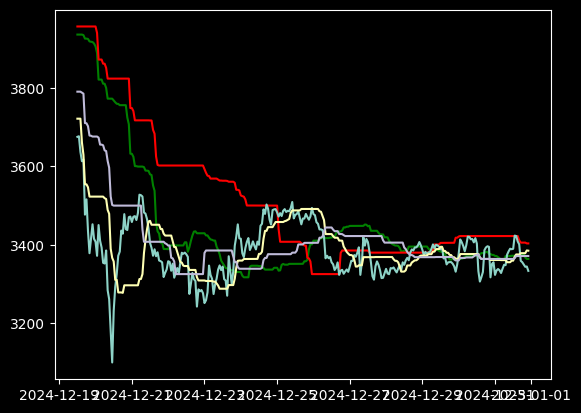

In [43]:
# Strategy
ichimoku = ta.trend.IchimokuIndicator(df['high'], df['low'], window1=20, window2=60, window3=120)
leading_span_a = ichimoku.ichimoku_a()
leading_span_b = ichimoku.ichimoku_b()
span_a_fwd = leading_span_a.shift(30)
span_b_fwd = leading_span_b.shift(30)

conversion_line = ichimoku.ichimoku_conversion_line()
base_line = ichimoku.ichimoku_base_line()

plt.plot(span_a_fwd[-300:-1],'g', label='Leading Span A')
plt.plot(span_b_fwd[-300:-1],'r', label='Leading Span B')
plt.plot(df['close'][-300:-1], label='Close Price')
plt.plot(conversion_line[-300:-1], label='Conversion Line')
plt.plot(base_line[-300:-1], label='Base Line')

# Insample permutation test

In [ ]:
from donchian import optimize_donchian 
    
    
train_df = df[(df.index.year >= 2018) & (df.index.year < 2020)]
best_lookback, best_real_pf = optimize_donchian(train_df)
print("In-sample PF", best_real_pf, "Best Lookback", best_lookback)


n_permutations = 1000
perm_better_count = 1
permuted_pfs = []
print("In-Sample MCPT")
for perm_i in tqdm(range(1, n_permutations)):
    train_perm = get_permutation(train_df)
    _, best_perm_pf = optimize_donchian(train_perm)

    if best_perm_pf >= best_real_pf:
        perm_better_count += 1

    permuted_pfs.append(best_perm_pf)

insample_mcpt_pval = perm_better_count / n_permutations
print(f"In-sample MCPT P-Value: {insample_mcpt_pval}")

plt.style.use('dark_background')
pd.Series(permuted_pfs).hist(color='blue', label='Permutations')
plt.axvline(best_real_pf, color='red', label='Real')
plt.xlabel("Profit Factor")
plt.title(f"In-sample MCPT. P-Value: {insample_mcpt_pval}")
plt.grid(False)
plt.legend()
plt.show()
